Necessário descrever minimamente o código.


In [ ]:
!pip install pyOpenBCI
!pip install mne
import os
import math
import time
import pickle
import pyOpenBCI
import collections
import numpy as np
import pandas as pd
import pywt # pacote Py Wavelets
from scipy.io import loadmat
from scipy.linalg import eigh
from datetime import datetime
from scipy.signal import welch, butter, lfilter, filtfilt, iirfilter, stft, morlet, cwt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.fftpack import fft
import mne

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/BCI_workgroup')
from bci_utils import extractEpochs, nanCleaner

In [5]:
# data, events, info = np.load('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/npy/A01T.npy', allow_pickle=True)
### to gdf file
eeg = mne.io.read_raw_gdf('/content/drive/MyDrive/BCI_workgroup/dataset/IV2a/A01T.gdf').load_data()
data = eeg.get_data()[:22] # [channels x samples]
events = mne.events_from_annotations(eeg) # raw.find_edf_events()
ch_names = eeg.ch_names

Extracting EDF parameters from /content/drive/MyDrive/BCI_workgroup/dataset/IV2a/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/local/lib/python3.7/dist-packages/mne/io/edf/edf.py:1044: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-5-962f0e884ae4>:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  eeg = mne.io.read_raw_gdf('/content/drive/MyDrive/BCI_workgroup/dataset/IV2a/A01T.gdf').load_data()


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [ ]:
events

(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 29683,      0,      5],
        ...,
        [670550,      0,      6],
        [670550,      0,      1],
        [671050,      0,      7]]),
 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10})

In [ ]:
for k,v in events[1].items(): print(f'{k} - {v}')

1023- 1
1072- 2
276- 3
277- 4
32766- 5
768- 6
769- 7
770- 8
771- 9
772- 10


In [ ]:
events = np.delete(events[0], 1, axis=1)
events

array([[     0,      5],
       [     0,      3],
       [ 29683,      5],
       ...,
       [670550,      6],
       [670550,      1],
       [671050,      7]])

In [ ]:
lb_utils = [7,8,9,10]

Fs = 250
smin = int(-2.0*Fs)
smax = int(6.0*Fs)

Z, t = extractEpochs(data, events, smin, smax, lb_utils)
for i,k in zip(lb_utils, range(1, 5)): t = np.where(t == i, k, t)

np.unique(t, return_counts=True)

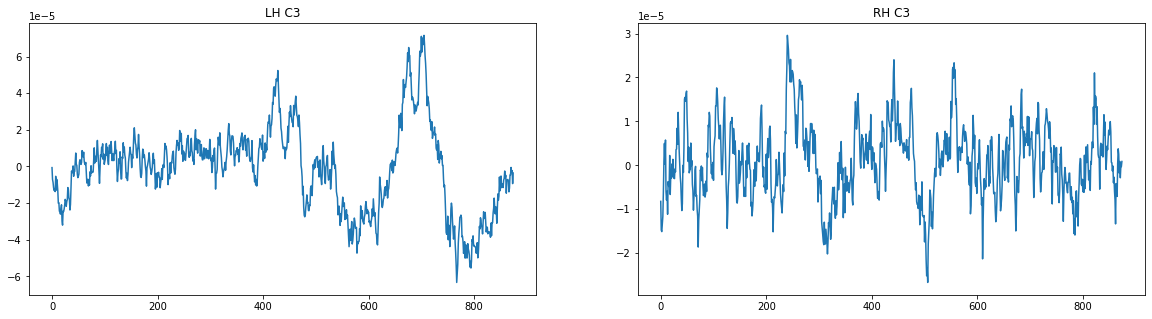

In [ ]:
class_ids = [1,2] # apenas lh e rh

Z = np.vstack([ Z[np.where(t == k)] for k in class_ids ])
t = np.hstack([ np.ones(len(Z)//2)*k for k in class_ids ]).astype(int) 

ch = 0 # 7,13 = hemisf esquerdo (atenua RH) 
# ch = 17 # 11,17 = hemisf direito (atenua LH)
lado = 'hemif. esquerdo' if ch in [7,13] else 'hemif. direito'

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(Z[71,ch].T) # lh
plt.title('LH C3')
plt.subplot(1,2,2)
plt.plot(Z[72,ch].T) # rh
plt.title('RH C3')
plt.show()

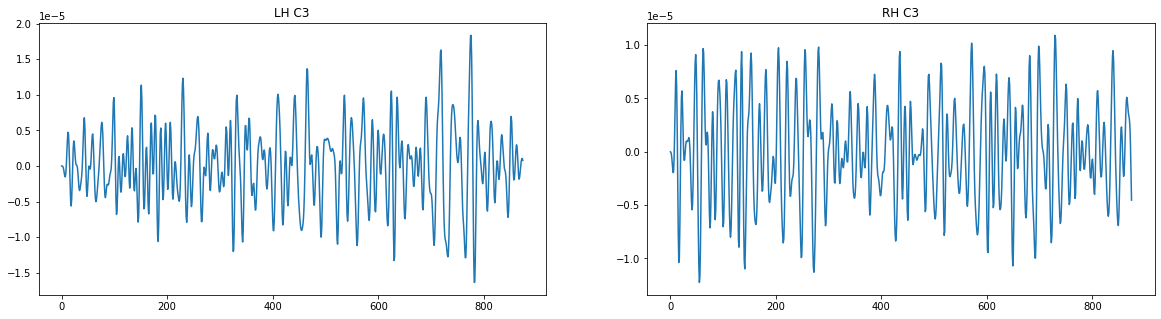

In [ ]:
# Filtering
b, a = butter(5, [8/125, 30/125], btype='bandpass')
# b, a = iirfilter(5, [8/125, 30/125], btype='band')
X = lfilter(b, a, Z) #filtfilt

# D = np.eye(22,22) - np.ones((22,22))/22
# X = np.asarray([D @ Z[i] for i in range(len(Z))])

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(X[71,ch].T) # lh
plt.title('LH C3')
plt.subplot(1,2,2)
plt.plot(X[72,ch].T) # rh
plt.title('RH C3')
plt.show()

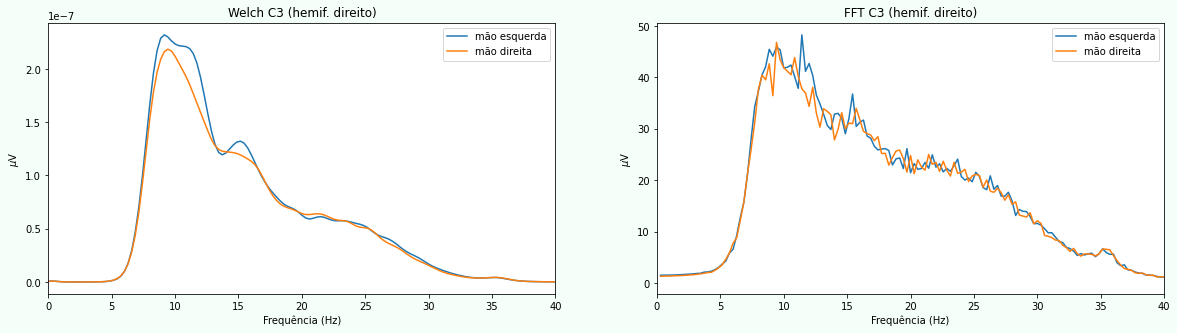

In [ ]:
Xa = X[:72, ch] # all epochs LH, C3
Xb = X[72:, ch] # all epochs RH, C3
 
## Welch
freq, pa = welch(Xa, fs=250, nfft=(Xa.shape[-1]-1)) # nfft=499 para q=500
_   , pb = welch(Xb, fs=250, nfft=(Xb.shape[-1]-1)) 
pa, pb = np.real(pa), np.real(pb)
ma, mb = np.mean(pa,0), np.mean(pb,0)
 
plt.subplots(figsize=(20, 5), facecolor='mintcream')
plt.subplot(1, 2, 1)
plt.plot(freq, ma*1e5, label='mão esquerda')  # np.log10(ma)
plt.plot(freq, mb*1e5, label='mão direita')
plt.xlim((0,40))
plt.title(f'Welch C3 ({lado})')
plt.ylabel(r'$\mu$V')
plt.xlabel('Frequência (Hz)')
plt.legend()
 
## FFT
T = 1/Fs
# freq = np.linspace(0.0, 1.0/(2.0*T), xa.shape[-1]//2)
freq = np.fft.fftfreq(Xa.shape[-1], T)
mask = freq>0
freq = freq[mask]
 
fa = np.abs(np.fft.fft(Xa))[:, mask]
fb = np.abs(np.fft.fft(Xb))[:, mask]
# fa = (2.0 * np.abs( fft(Xa) / Xa.shape[-1]))[:, mask]
# fb = (2.0 * np.abs( fft(Xb) / Xb.shape[-1]))[:, mask]
 
ma, mb = np.mean(fa,0), np.mean(fb,0)
 
plt.subplot(1, 2, 2)
plt.plot(freq, ma*1e5, label='mão esquerda')
plt.plot(freq, mb*1e5, label='mão direita')
plt.xlim((0,40))
plt.title(f'FFT C3 ({lado})')
plt.ylabel(r'$\mu$V')
plt.xlabel('Frequência (Hz)')
plt.legend()